# ShiftIfYouCan Example Notebook

In this notebook we present a walkthrough example for the ShiftIfYouCan visualisation code. 


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Setup

First we have to import all needed modules.

In [2]:
import numpy as np

# Internal functions
from modules.ext_libraries import f_measure, variations
from modules.operating import operation_count, process_operations, get_variation, get_summary
from modules.plotting import plot_operations

By using the magic `%matplotlib notebook`, interaction (zoom in, out, save) with the figure is enabled.

*Note: zoom-in is higly resource-intensive and may be quite slow*

In [3]:
# Uncomment/comment this line if you do/don't need interaction
%matplotlib notebook 

import matplotlib.pyplot as plt
FIGSIZE = (18, 2.5)
plt.rcParams['figure.figsize'] = FIGSIZE

## Start the Analysis

First we load the beat detections and ground-truth annotations. The examples provided correspond to a highly expressive piece of music.  
Then we obtain a list of the corrected detections (`corrected`), that can be saved for further use within a tool such as [Sonic Visualiser](https://www.sonicvisualiser.org/).  

We print a summary of the operations in a friendly manner, that provides the proposed **annotation efficiency**, defined as follows: 
\begin{equation}
ae = t^{+} / (t^{+} + s + f^{+} + f^{-}),
\end{equation}
where $t^{+}$ is the number of true positives, $s$ is the number of shifts, and $f^{-}$ and $f^{+}$ correspond to false negatives and false positives, respectively.
that displays the number of each operation required to transform the detection, thus maximising the (transformed) F-Measure.

In [4]:
# Load the beat detections (dets) and the ground-truth annotation (anns)
dets = np.loadtxt('dets.txt')
anns = np.loadtxt('hains006.beats')

# use only the first column (i.e. the time stamp) if these are 2D
if dets.ndim > 1:
    dets = dets[:, 0]
if anns.ndim > 1:
    anns = anns[:, 0]

In [5]:
# Get matrix of operations and annotation efficiency
ops, ann_eff = operation_count(dets, anns)

# Get list of transformed detections
transformed = process_operations(ops)

# Save list of transformed detections
np.savetxt('dets_transformed.txt', transformed, fmt='%.2f')

# Get combined F-measure (tuple with initial F-measure and transformed F-measure)
comb_f_measure = f_measure(dets, anns), f_measure(transformed, anns)

# Display results
print(get_summary('dets', ann_eff, comb_f_measure))

- - - - - - - - - - - - - - - - -
dets      
- - - - - - - - - - - - - - - - -
annotation_efficiency: 0.877
  # "good" detections: 57
  # insertions: 3
  # deletions: 1
  # shifts: 4

(initial) f-measure: 0.905
(transformed) f_measure: 1.000



# Visualisation

We provide an open-source Python implementation which graphically displays the minimum set and type of operations required to transform a sequence of initial beat  detections in such a way as to maximize the F-measure when comparing the transformed detections against a ground truth annotation sequence. 

Here we present some examples to demonstrate the usefulness of this rich visualisation of beat tracking evaluation.
All the figures are plotted in interactive mode to allow the user to go into greater detail by zooming in specific parts of the plot.

Note: Besides the configuration provided by the parametererisation of the function plot_operations(), a group of module-level control variables is defined at the top of the module *plotting.py*, where all the plotting functionality is implemented. 


<IPython.core.display.Javascript object>


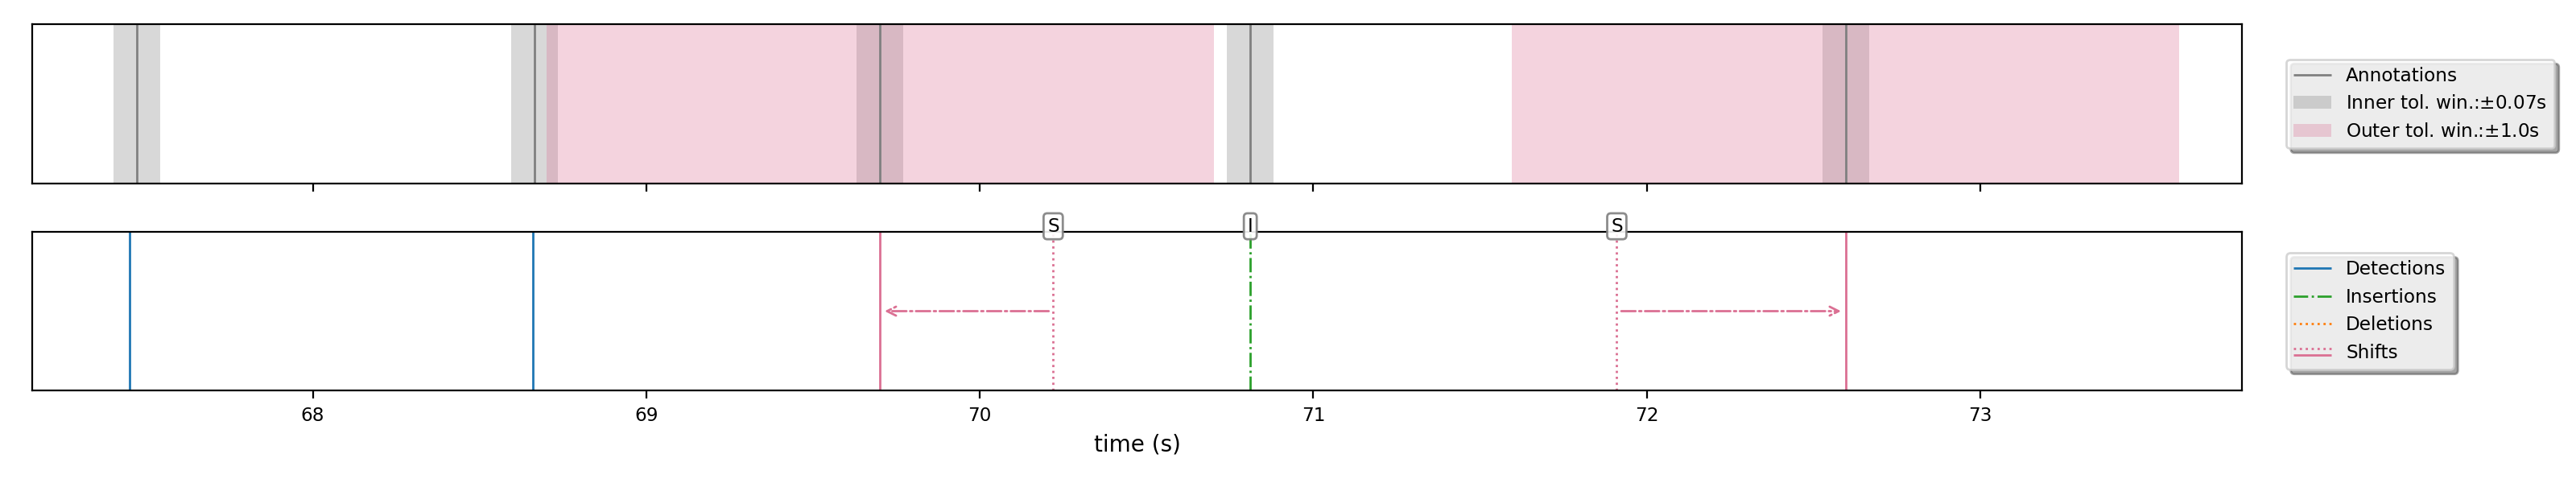

In [6]:
# Display visualisation
fig,ax = plot_operations(ops, anns, 'Original')
plt.tight_layout()
plt.show()


We can manually zoom in by using the tools in the navigation bar of the figure. For demonstration purposes, we'll zoom programatically, e.g. the area between 68 secs and 73 secs. 
In this area of the figure, we can observe the following: 
- 1 **correct detection** (at 68.6 secs), clearly within the *inner* tolerance window, depicted as a grey background surrounding the annotation;
- 2 **shifts**, also within the *outer* tolerance window, depicted as a pink background surrounding the annotation; the original ("unshifted") locations of the detections are show as dotted lines (at 70.2 and 71.9 secs) and the final locations of the shifts are depicted as solid lines (at 69.7 and 72.6 secs). 
- 1 **insertion** (at 70.8 secs). In this case, as there was not any detection (to consider as correct detection) available within the inner tolerance window, neither any detection (to consider as shift) within the outer tolerance window (only drawn when a shift is considered), a **insertion** was accounted.  


In [8]:
# Zoom the image
ax[0].set_xlim(68, 73) # only when in "interactive" mode 

(68.0, 73.0)

Finally, we can change the sizes of the inner and outer tolerance windows and update all the calculations and visualisation. We just have to pass the new values for both tolerance windows as (optional) parameters of the corresponding functions.

- - - - - - - - - - - - - - - - -
dets      
- - - - - - - - - - - - - - - - -
annotation_efficiency: 0.859
  # (correct) detections: 55
  # insertions: 2
  # deletions: 0
  # shifts: 7

(initial) f-measure: 0.873
(transformed) f_measure: 1.000



<IPython.core.display.Javascript object>


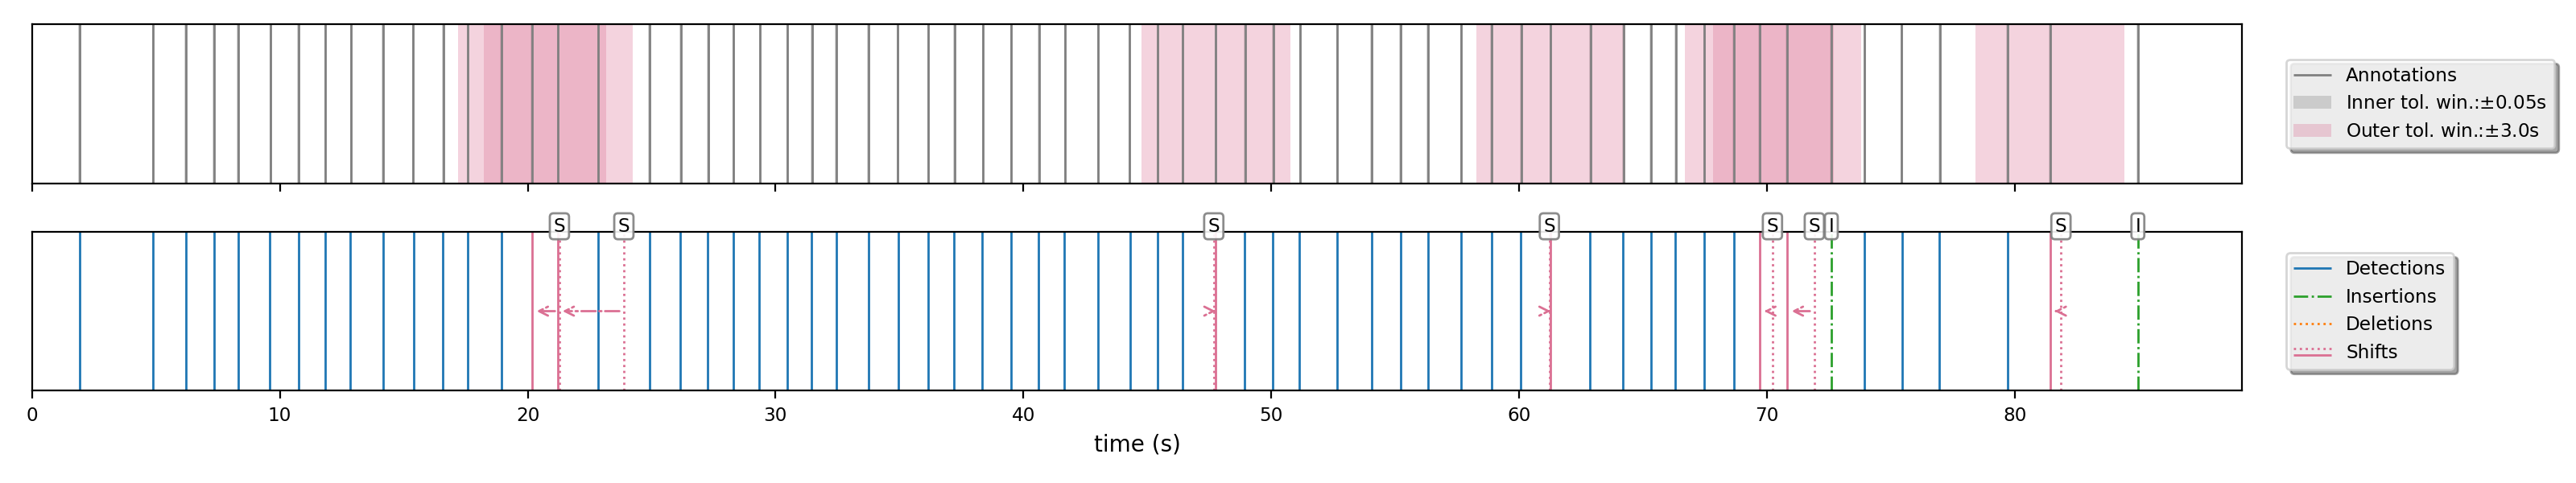

In [9]:
# Get matrix of operations and annotation efficiency
ops, ann_eff = operation_count(dets, anns, inn_tol_win=0.05, out_tol_win=3.0)

# Get list of transformed detections
transformed = process_operations(ops)

# Save list of transformed detections
np.savetxt('dets_transformed.txt', transformed, fmt='%.2f')

# Get combined F-measure (tuple with initial F-measure and transformed F-measure)
comb_f_measure = f_measure(dets, anns, inn_tol_win=0.05), f_measure(transformed, anns, inn_tol_win=0.05)

# Display results
print(get_summary('dets', ann_eff, comb_f_measure))

# Display visualisation
fig,ax = plot_operations(ops, anns, inn_tol_win=0.05, out_tol_win=3.0)
plt.tight_layout()
plt.show()

### Metrical Ambiguity

To allow for metrical ambiguity in beat tracking evaluation, it is common to create a set of variations of the ground truth by interpolation and sub-sampling operations. In our implementation, we flip this behaviour, and instead create the following variants of the beat detections:
- *Offbeat*: 180 degrees out of phase from the original beat locations;
- *Double*: Beats at 2x the original tempo;
- *Half-odd*: Half of the original tempo, only the odd beats;
- *Half-even*: Half of the original tempo, only the even beats;
- *Triple*: Beats at 3x the original tempo;
- *Third-1*: A Third of the original tempo, 1st beat (1,4,3,2,..)
- *Third-2*: A Third of the original tempo, 2nd beat (2,1,4,3,..)
- *Third-3*: A Third of the original tempo, 3rd beat (3,2,1,4,..)



In [10]:
# Get all variations of beat detections
dets_variations, types_variations = variations(dets)

Now let's analyse one of the provided variations: e.g. the **Offbeat** variation, which is a version 180 degrees out of phase from the original beat locations.
As we would expect, the values for the annotation efficiency are worse than for the original beat detection: 0.015 vs 0.877.

- - - - - - - - - - - - - - - - -
Offbeat   
- - - - - - - - - - - - - - - - -
annotation_efficiency: 0.015
  # (correct) detections: 1
  # insertions: 6
  # deletions: 3
  # shifts: 57

(initial) f-measure: 0.016
(transformed) f_measure: 1.000



<IPython.core.display.Javascript object>


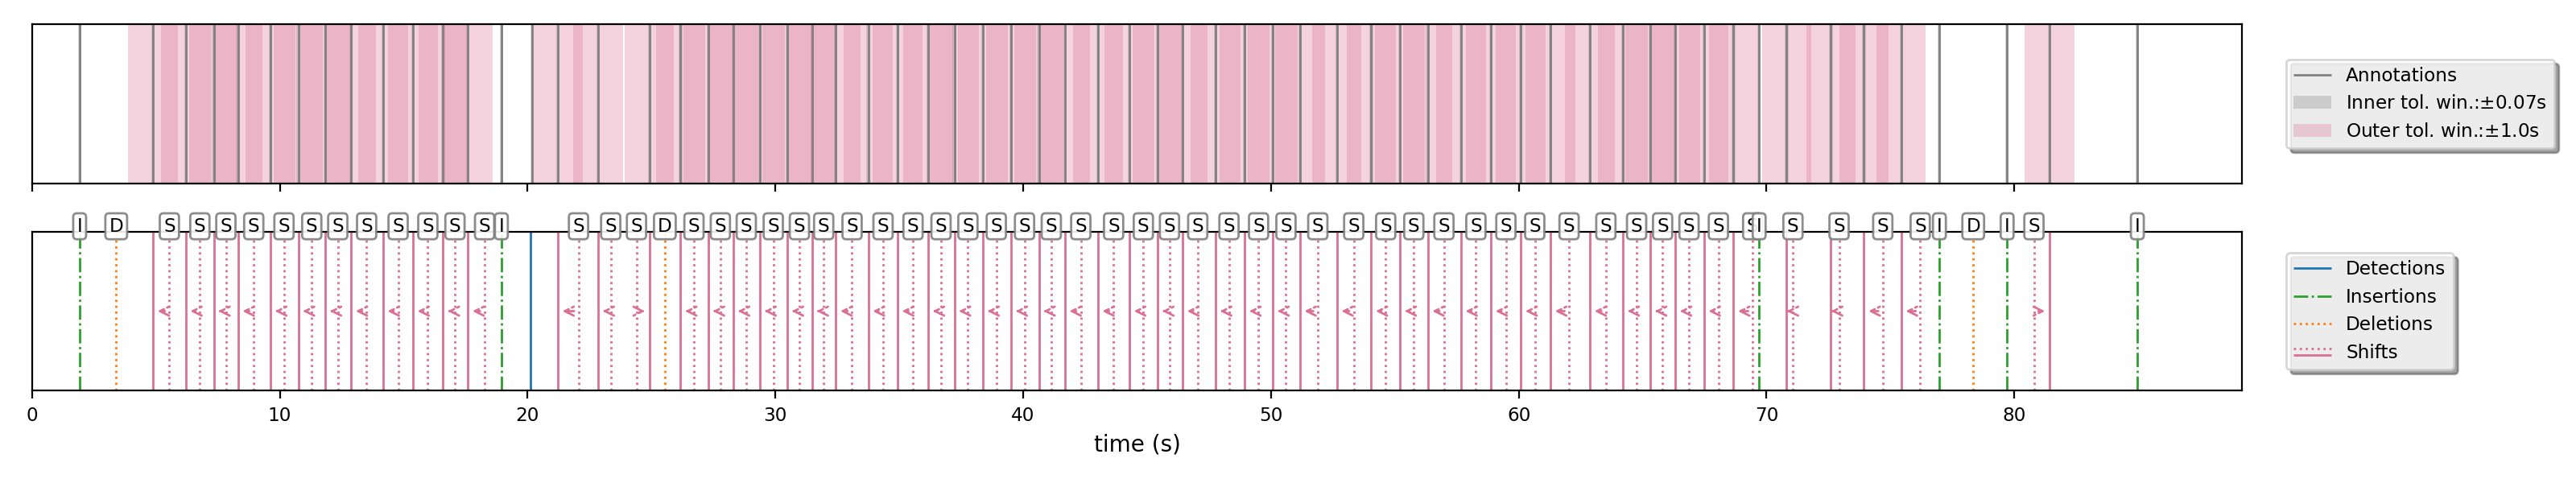

In [11]:
# Select specific variation of the beat detections
type_variation = 'Offbeat'
dets_variation = get_variation(type_variation, dets_variations, types_variations)

# Get matrix of operations and annotation efficiency
ops, ann_eff = operation_count(dets_variation, anns)

# Get list of transformed detections
transformed = process_operations(ops)

# Get combined f-measure (tuple with initial f-measure and transformed f-measure)
comb_f_measure = f_measure(dets_variation, anns), f_measure(transformed, anns)

# Display summary results
print(get_summary(type_variation, ann_eff, comb_f_measure))

# Get the figure
fig = plot_operations(ops, anns, type_variation)

# Show the plot
plt.tight_layout()
plt.show()

Now let's do the same analysis for the **Double** variation, where the beats occur at 2x the original tempo.

- - - - - - - - - - - - - - - - -
Double    
- - - - - - - - - - - - - - - - -
annotation_efficiency: 0.468
  # (correct) detections: 58
  # insertions: 1
  # deletions: 60
  # shifts: 5

(initial) f-measure: 0.620
(transformed) f_measure: 1.000



<IPython.core.display.Javascript object>


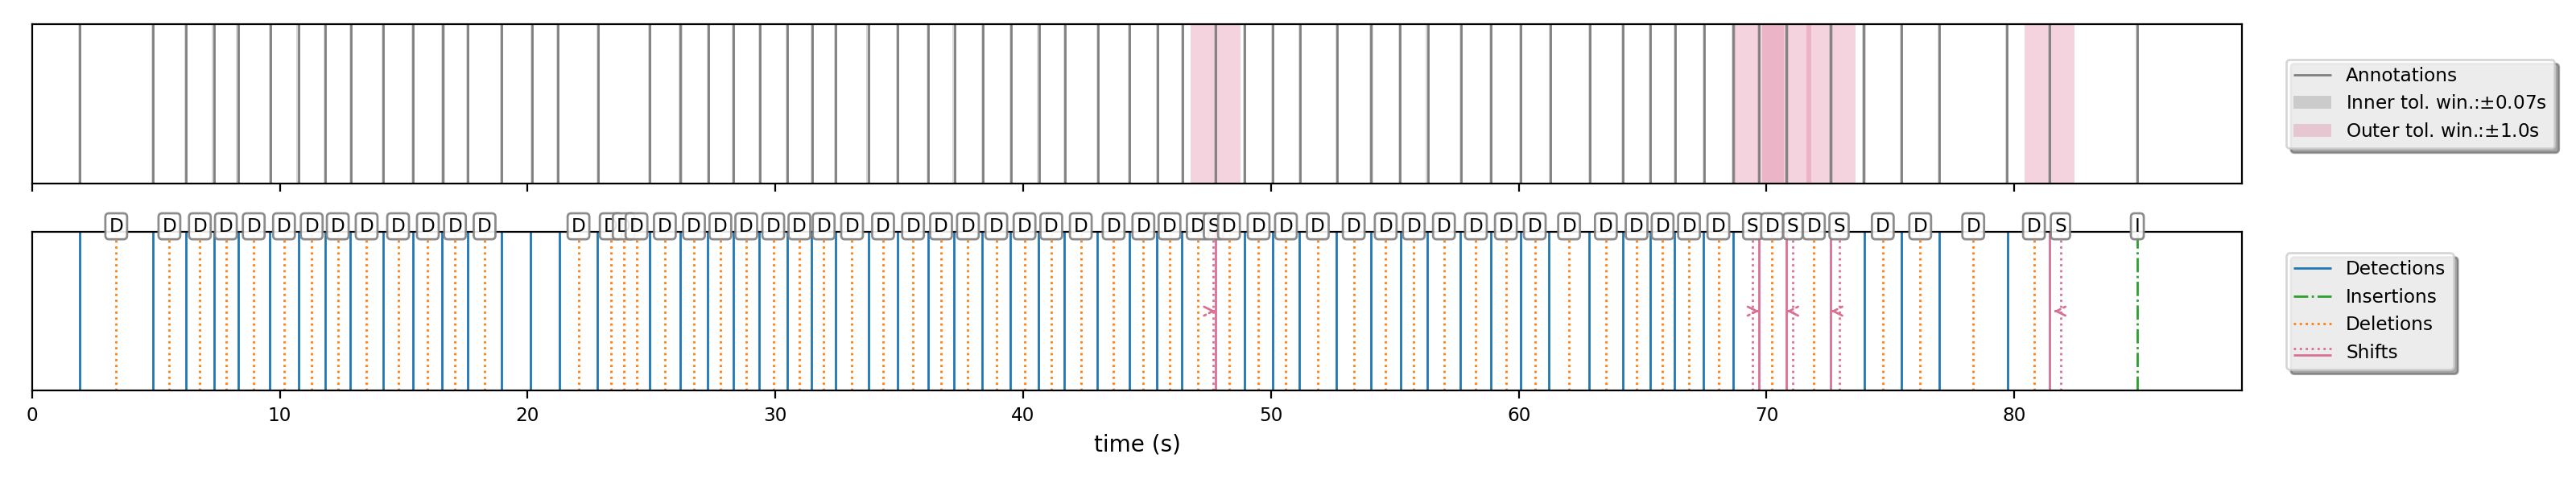

In [12]:
# Select specific variation of the beat detections
type_variation = 'Double'
dets_variation = get_variation(type_variation, dets_variations, types_variations)

# Get matrix of operations and annotation efficiency
ops, ann_eff = operation_count(dets_variation, anns)

# Get list of transformed detections
transformed = process_operations(ops)

# Get combined f-measure (tuple with initial f-measure and transformed f-measure)
comb_f_measure = f_measure(dets_variation, anns), f_measure(transformed, anns)

# Display summary results
print(get_summary(type_variation, ann_eff, comb_f_measure))

# Get the figure
fig = plot_operations(ops, anns, type_variation)

# Show the plot
plt.tight_layout()
plt.show()